[View in Colaboratory](https://colab.research.google.com/github/sb215/PICpy/blob/master/PIC-master.ipynb)

# PIC simulation
(Reference : Particle-based simulation of plasmas, Giovanni Lapenta, February 12, 2017)

- Simplest case : 1D and electrostatic
- Electrons being followed as particles but ions forming a fixed background of uniform density.
    - This is justified by the heavy mass of the ions.

## 1. Initialization
1. Setting up jupyter notebook environment
2. Import some python library
3. Initialize definition of the simulation
    - Discretize in terms of domain size and of the grid
    - Set time step with the number of cycles to be run
    - Define Plasma density
        - Here use normalized units : plasma freq is unitary
    - Charge neutral : The ion uniform background is set to exactly balance the charge of the particles

In [0]:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
#  'all' | 'last' | 'last_expr' | 'none'
# %config InlineBackend.figure_format = 'retina'

from IPython.display import HTML

In [0]:
import numpy as np
from scipy import sparse
from scipy.sparse import linalg
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation, FFMpegFileWriter

In [0]:
#@title Simulation parameters

# Domain size
L = 2 #@param {type:"slider", min:0, max:10, step:1}
L *= np.pi
# Number of grid cells
NG = 30 #@param {type:"slider", min:0, max:100, step:5} 
# Number of particles for each cell
NP = 30 #@param {type:"slider", min:0, max:100, step:10}

# Time step
DT = 0.1 #@param {type:"slider", min:0, max:10, step:0.1} 
# Number of time steps
NT = 100 #@param {type:"slider", min:0, max:1000, step:10} 

N = NG * NP  # Number of particles
dx = L / NG  # Cell size

WP = 1. # Plasma frequency
QM = -1. # Charge/mass ratio
Q = WP**2 / (QM*N/L) # rho0*L/N: charge carried by a single particle
rho_back = -Q*N/L # Background charge density

## 2. Particle Initialization
- Example : two-stream instability
    - two equal beams of initial electrons
    - opposite mean velocity but equal density and thermal speed
    
- We can add perturbation to excite the desired mode (of sine function)

In [0]:
#@title Particle initial properties

# Stream velocity
V0 = 0.2 #@param {type:"slider", min:0, max:1, step:0.1}
# Thermal speed
VT = 0.0000001 #@param {type:"slider", min:0, max:0.000001, step:0.0000001}

# perturbation
XP1 = 1.0 #@param {type:"slider", min:0, max:10, step:1}
mode = 1 #@param {type:"slider", min:0, max:10, step:1}

# particles (electrons)
xp = np.linspace(0, L-L/N, N).T # Particle positions
vp = VT * np.random.randn(N) # Particle momentum, initially Maxwellian
pm = np.arange(N)
pm = 1 - 2 * np.mod(pm+1, 2) # Even and odd particles have opposite speed
vp += pm * V0 # Momentum + stream velocity
np.random.shuffle(vp) # We reshuffle the indices to avoid any bias


# Add electron perturbation to excite the desired mode
xp += XP1 * (L/N) * np.sin(2 * np.pi * xp / L * mode)
xp[np.where(xp < 0)] += L
xp[np.where(xp >= L)] -= L

## 3. Grid Initialization
- In the 1D electrostatic limit, the Maxwell equations reduce to just the Poisson equation:

    $$ -\varepsilon_0 \nabla^2 \phi = e(n_i - n_e)$$

    - $n_i$ : uniform background ion density
    - $n_e$ : the electron density projected to the grid from the particles

- Discretize laplacian using simple finite difference method

$$ - \varepsilon_0 (\phi_{i+1} + \phi_{i-1} - 2\phi_i) = e(n_i-n_e)\Delta_x^2$$

- The potential is computed in the cell centres.
    - The continuum is subdivided in cells indexed by $i \in [0, NG-1]$ 

- Boundary condition
    - Periodic boundary
    - Potential is defined as a negative constant
        - potential in the last cell is 0
        - The number of unknown potentials then is just NG-1.
    - Resulting matrix : -2 on the diagonal & 1 on the neighbouring diagonal

In [0]:
# Auxiliary vectors
p = np.concatenate([np.arange(N), np.arange(N)]) # Particle indices up to N
Poisson = sparse.spdiags(([1, -2, 1] * np.ones((1, NG-1), dtype=int).T).T, [-1, 0, 1], NG-1, NG-1)
Poisson = Poisson.tocsc()

## 4. Main Cycle
- Four steps for each cycle
    1. Advance the position
    2. Compute the density from projected particle to the grid
    3. Solve Poission equation
    4. Compute electric field & force
    5. Advance the particle velocity

In [0]:
nT=0

def cycle(xp,vp):
    global rho, Eg, nT, Phi
    nT += DT
    # update particle position xp
    xp += vp * DT
    
    # Periodic boundary condition
    xp[np.where(xp < 0)] += L
    xp[np.where(xp >= L)] -= L
    
    # Project particles->grid
    csi = xp/dx
    g1 = np.floor(csi - 0.5) # Distance from the centre of the cell
    g = np.concatenate((g1, g1+1))
    fraz1 = 1 - np.abs(xp/dx - g1 - 0.5)
    fraz = np.concatenate((fraz1, 1-fraz1))
    g[np.where(g < 0)] += NG
    g[np.where(g > NG-1)] -= NG
    mat = sparse.csc_matrix((fraz, (p, g)), shape=(N, NG))
    rho = Q / dx * mat.toarray().sum(axis=0) + rho_back
    
    # Compute electric field potential
    Phi = linalg.spsolve(Poisson, -dx**2 * rho[0:NG-1])
    Phi = np.concatenate((Phi,[0]))
    
    # Electric field on the grid
    Eg = (np.roll(Phi, 1) - np.roll(Phi, -1)) / (2*dx)
    
    # interpolation grid->particle and velocity update
    vp += mat * QM * Eg * DT

## 5. Diagnostics

- Particle diagnostics
    - Phase space plot : $x_p vs. v_p$
    - Velocity Distribution function : histogram of particle counts in energy bins
    
- Field diagnostics
    - Electric filed on the grid vs. time
    - FFT modes of the filed quantites

- Other information
    - Total Kinetic Energy : $E_k = \frac{1}{2} \sum_p m_p v_p^2$
    - Total Momentum : $P = \sum_p m_p v_p$
    - Total Energy of the field : $E_E = \Delta x \sum_c \frac{\varepsilon_0 E^2}{2} \equiv \Delta x \sum_c \frac{\rho \phi}{2}$

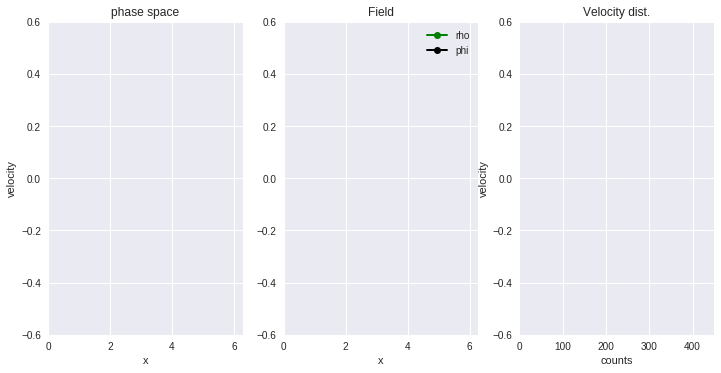

In [7]:
from matplotlib.widgets import TextBox

#fig = plt.figure()
fig, ax = plt.subplots(1, 3, figsize=(10,5))
#ax = fig.add_subplot(211, aspect='equal', autoscale_on=False,
#                     xlim=(0, L), ylim=(-3*V0, 3*V0))
#ax.grid()
plt.tight_layout()


ax[0].set_xlim(0, L)
ax[0].set_ylim(-3*V0, 3*V0)
ax[0].set_xlabel('x')
ax[0].set_ylabel('velocity')
ax[0].set_title("phase space")

plotlays, plotcols = [2], ["blue","red"]
lines = []
for index in range(2):
    lobj = ax[0].plot([],[],'.',lw=2,color=plotcols[index])[0]
    lines.append(lobj)
        

ax[1].set_xlim(0, L)
ax[1].set_ylim(-3*V0, 3*V0)
ax[1].set_xlabel('x')
#ax[1].set_ylabel('velocity')
ax[1].set_title("Field")

plotlays2, plotcols2 = [2], ["green","black"]
lines2 = []
for index in range(2):
    lobj2 = ax[1].plot([],[],'o-',lw=2,color=plotcols2[index])[0]
    lines2.append(lobj2)
ax[1].legend(["rho","phi"])
    
time_text = ax[1].text(0.02, 0.95, '', transform=ax[1].transAxes)
KE_text = ax[1].text(0.02, 0.90, '', transform=ax[1].transAxes)
PE_text = ax[1].text(0.02, 0.85, '', transform=ax[1].transAxes)
TE_text = ax[1].text(0.02, 0.80, '', transform=ax[1].transAxes) 
    
def vdf():
    ax[2].cla()    
    ax[2].set_ylim(-3*V0, 3*V0)
    ax[2].set_xlim(0, N/2)
    ax[2].set_ylabel('velocity')
    ax[2].set_xlabel('counts')
    ax[2].set_title("Velocity dist.")
    
    
   
  
# initialization function: plot the background of each frame
def init():
    vdf()
    for line in lines:
        line.set_data([],[])
        
    for line in lines2:
        line.set_data([],[])  
    
    time_text.set_text('')
    KE_text.set_text('')
        
    return lines

adr1=np.where(vp>=0)
adr2=np.where(vp<0)

def updatefig(*args):
    cycle(xp,vp)
    xlist=[xp[adr1], xp[adr2]]
    ylist=[vp[adr1], vp[adr2]]

    #for index in range(0,1):
    for lnum,line in enumerate(lines):
        line.set_data(xlist[lnum], ylist[lnum]) # set data for each line separately. 
        
    vdf()
    ax[2].hist(vp, orientation='horizontal')    
        
    lines2[0].set_data(np.arange(0,NG)*dx,rho)
    lines2[1].set_data(np.arange(0,NG)*dx,Phi)
    
    KE=np.sum(np.power(vp,2))/2
    PE=dx/2*np.sum(rho*Phi)
    TE=KE+PE

    time_text.set_text('simulation time : %.1f' % nT)
    KE_text.set_text('Total K.E. : % .3f' % KE)
    PE_text.set_text('Total P.E. : % .3f' % PE)
    TE_text.set_text('Total E. : % .3f' % TE)
    
    return lines


anim = FuncAnimation(fig, updatefig, init_func=init, frames=NT, blit=True)


#plt.rcParams['animation.html'] = 'jshtml'
#plt.show()


In [8]:
#@title 기본 제목 텍스트

#HTML(anim.to_html5_video())

HTML(anim.to_jshtml())
#anim.save('test.htm', fps=20, dpi=50)
#plt.show()


#HTML(anim.to_html5_video())
#mywriter = FFMpegFileWriter(fps=25,codec="libx264")
#anim.save("test.mp4", writer=mywriter)
